In [1]:
import os
import numpy as np
import network
import convert
import torch
from simulation import (
    CompressionSimulation,
    LJSimulation,
    TemperatureRange,
    gen_sim_data,
)
import networkx as nx
import matplotlib.pyplot as plt
import random
from utils import draw_network, recalc_bond, recalc_bonds, inject_noise

calc_dir = "/home/sergey/work/simulator_data_gen/test_networks" # work

2


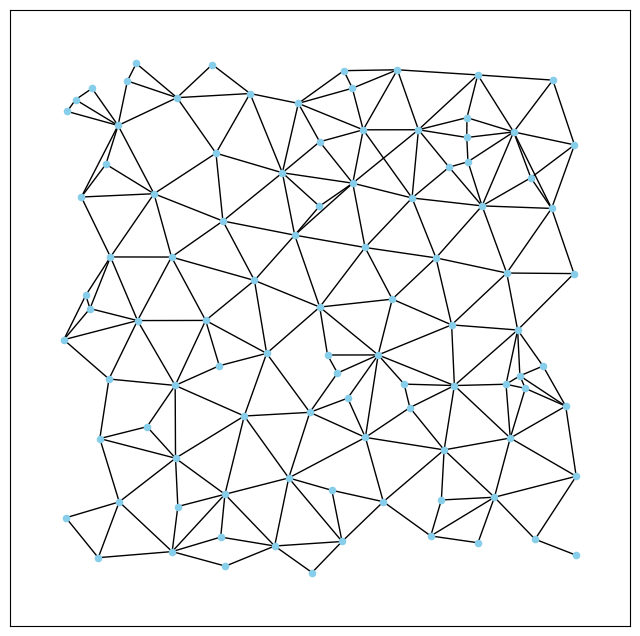

In [7]:
from simulation import run_lammps_calc


def randomize_LJ(n_atoms: int):
    atom_types = random.randint(2, 2)
    # atom_sizes = [random.uniform(0.3, 4.0) for i in range(atom_types)]
    print(atom_types)
    # print(atom_sizes)
    lj_sim = LJSimulation(
        n_atoms=n_atoms,
        n_atom_types=atom_types,
        atom_sizes=[0.3, 1.0],
        box_dim=[-40, 40, -40, 40, -0.1, 0.1],
        temperature_range=TemperatureRange(T_start=0.005, T_end=0.001, bias=10.0),
        Kn=0.5,
        n_parts=[40, 60],
        n_steps=30000
    )
    return lj_sim

d = "/home/sergey/work/simulator_data_gen/test"
lj_sim = randomize_LJ(120)
lj_sim.write_to_file(d)
run_lammps_calc(d, input_file='lammps.in')
net = network.Network.from_atoms(os.path.join(d, "coord.dat"))
net.write_to_file(os.path.join(d, "network.lmp"))
# net = inject_noise(net, angle_coeffs=0.00)
draw_network(net, periodic_edges=False)

In [10]:
from sim_var_cli import prune_edges
from simulation import run_lammps_calc


calc_dir = "/home/sergey/work/simulator_data_gen/more_random"
for i in range(40):
    loc_dir = os.path.join(calc_dir, str(i))
    os.makedirs(loc_dir)
    lj_sim = LJSimulation(
        n_atoms=100,
        n_atom_types=3,
        atom_sizes=[1.6, 1.2, 0.9],
        box_dim=[-40, 40, -40, 40, -0.1, 0.1],
        temperature_range=TemperatureRange(0.005, 0.0001, 10.0),
        n_steps=30_000,
    )
    lj_sim.write_to_file(loc_dir)
    run_lammps_calc(loc_dir, input_file='lammps.in')

    ord_network = network.Network.from_atoms(
        os.path.join(loc_dir, "coord.dat"),
        include_default_masses=1e6,
    )
    ord_network = prune_edges(ord_network, 0.8)
    ord_network.set_angle_coeff(0.00)
    ord_network.write_to_file(os.path.join(loc_dir, f"network{i}.lmp"))
    comp_sim = CompressionSimulation(
        box_size=ord_network.box.x,
        network_filename=f"network{i}.lmp",
        strain=0.03,
        temperature_range=TemperatureRange(1e-7, 1e-7, 10.0)
    )
    comp_sim.write_to_file(loc_dir)
    run_lammps_calc(loc_dir, input_file="in.deformation")

In [11]:
from convert import parse_dump

ord_data = []
for i in range(5):
    loc_dir = os.path.join(calc_dir, str(i))
    ord_network = network.Network.from_data_file(
        os.path.join(loc_dir, f"network{i}.lmp"),
        include_default_masses=1e6,
    )
    sim = parse_dump(
        os.path.join(loc_dir, "dump.lammpstrj"),
        ord_network,
        node_features="coord"
    )

    ord_data.append(sim)

ord_data

[[Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.247 : 5.247) (-5.247 : 5.247) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.246 : 5.246) (-5.247 : 5.247) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.246 : 5.246) (-5.247 : 5.247) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.245 : 5.245) (-5.248 : 5.248) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.245 : 5.245) (-5.248 : 5.248) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.244 : 5.244) (-5.248 : 5.248) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.244 : 5.244) (-5.248 : 5.248) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.243 : 5.243) (-5.248 : 5.248) (-0.1 : 0.1)),
  Data(x=[99, 2], edge_index=[2, 285], edge_attr=[285, 4], box=Box (-5.2

In [12]:
torch.save(ord_data, "/home/sergey/work/gnn/NN_Simulator/pruned08.pt")

In [ ]:
def draw_network(
    net: network.Network,
    edges: bool = True,
    periodic_edges: bool = True,
    box: bool = False,
    node_color: str = "skyblue",
    standalone: bool = True,
    node_size: float = 20,
    figure_scale: float = 3,
):
    if standalone:
        plt.figure(figsize=(8, 8))
    G = nx.Graph()
    # Add nodes
    for atom in net.atoms:
        G.add_node(atom.atom_id)

    pos = {atom.atom_id: (float(atom.y), float(atom.x)) for atom in net.atoms}

    # Add edges
    if edges:
        edge_index = [(bond.atom1.atom_id, bond.atom2.atom_id) for bond in net.bonds]
        naive_edge_lengths = [bond.atom1.dist(bond.atom2) for bond in net.bonds]
        for edge, length in zip(edge_index, naive_edge_lengths):
            if periodic_edges:
                G.add_edge(edge[0], edge[1])
            else:
                if length < net.box.x // 2:
                    G.add_edge(edge[0], edge[1])

    if box:
        B = nx.Graph()
        box_corners = [
            (net.box.x1, net.box.y1),
            (net.box.x1, net.box.y2),
            (net.box.x2, net.box.y1),
            (net.box.x2, net.box.y2),
        ]
        box_edges = [
            [box_corners[0], box_corners[1]],
            [box_corners[1], box_corners[2]],
            [box_corners[2], box_corners[3]],
            [box_corners[3], box_corners[0]],
        ]

        for corner, edge in zip(box_corners, box_edges):
            B.add_node(corner)
            B.add_edge(edge[0], edge[1])
        b_pos = {}
        b_pos[box_corners[0]] = (net.box.x1, net.box.y2)
        b_pos[box_corners[1]] = (net.box.x2, net.box.y2)
        b_pos[box_corners[2]] = (net.box.x2, net.box.y1)
        b_pos[box_corners[3]] = (net.box.x1, net.box.y1)

        nx.draw_networkx(B, b_pos, with_labels=False, node_color="black", node_size=1)

    nx.draw_networkx(
        G,
        pos,
        with_labels=False,
        node_color=node_color,
        node_size=node_size,
        font_size=10,
    )
    # nx.draw_networkx(G, with_labels=False, node_color=node_color, node_size=node_size, font_size=10)
    if standalone:
        plt.show()



In [ ]:
example = network.Network.from_data_file("data/raw/noised_prund/140_4/network_data/2/network.lmp")
draw_network(example, periodic_edges=False)

In [ ]:
from utils import load_data


data = load_data('noisy_networks.pt')